## Self driving car model

In [1]:
!git clone https://github.com/tzudir/Self_driving

Cloning into 'Self_driving'...
remote: Enumerating objects: 33843, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 33843 (delta 2), reused 0 (delta 0), pack-reused 33837
Receiving objects: 100% (33843/33843), 418.28 MiB | 20.85 MiB/s, done.
Resolving deltas: 100% (56/56), done.
Updating files: 100% (33728/33728), done.


In [2]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Lambda, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import ntpath

In [3]:
datadir = '/content/Self_driving/data2'
# columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'))
pd.set_option('display.max_colwidth', -1)

<ipython-input-3-1f81fe59d11c>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [4]:
data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [5]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [6]:
data.head()

,center,left,right,steering,throttle,brake,speed
0,center_2016_12_01_13_30_48_287.jpg,left_2016_12_01_13_30_48_287.jpg,right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,center_2016_12_01_13_30_48_404.jpg,left_2016_12_01_13_30_48_404.jpg,right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,center_2016_12_01_13_31_12_937.jpg,left_2016_12_01_13_31_12_937.jpg,right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,center_2016_12_01_13_31_13_037.jpg,left_2016_12_01_13_31_13_037.jpg,right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,center_2016_12_01_13_31_13_177.jpg,left_2016_12_01_13_31_13_177.jpg,right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


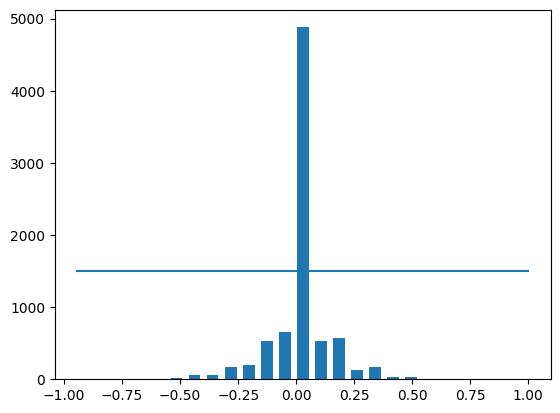

In [7]:
num_bins = 25
samples_per_bin = 1500
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [8]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

removed:  3380
remaining:  4656


In [9]:
hist, bins = np.histogram(data['steering'], (num_bins))

In [10]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [11]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [12]:
image_paths

array(['/content/Self_driving/data2/IMG/center_2016_12_01_13_30_48_287.jpg',
       '/content/Self_driving/data2/IMG/left_2016_12_01_13_30_48_287.jpg',
       '/content/Self_driving/data2/IMG/right_2016_12_01_13_30_48_287.jpg',
       ...,
       '/content/Self_driving/data2/IMG/center_2016_12_01_13_46_38_846.jpg',
       '/content/Self_driving/data2/IMG/left_2016_12_01_13_46_38_846.jpg',
       '/content/Self_driving/data2/IMG/right_2016_12_01_13_46_38_846.jpg'],
      dtype='<U66')

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state = 6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 11174
Valid Samples: 2794


In [14]:
# fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
# axes[0].set_title('Training set')
# axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
# axes[1].set_title('Validation set')

In [15]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle


In [16]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [17]:
def img_preprocess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [18]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [19]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5), activation='elu'))


  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))

  model.add(Dense(50, activation = 'elu'))

  model.add(Dense(10, activation = 'elu'))


  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 18, 64)         76864     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               115300    
                                                                 
 dense_1 (Dense)             (None, 50)                5

In [20]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=13,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

<ipython-input-20-395cf1ba442f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


Epoch 1/13
300/300 [==============================] - 145s 463ms/step - loss: 0.0953 - val_loss: 0.0330
Epoch 2/13
300/300 [==============================] - 122s 408ms/step - loss: 0.0316 - val_loss: 0.0271
Epoch 3/13
300/300 [==============================] - 121s 405ms/step - loss: 0.0277 - val_loss: 0.0229
Epoch 4/13
300/300 [==============================] - 120s 401ms/step - loss: 0.0248 - val_loss: 0.0219
Epoch 5/13
300/300 [==============================] - 124s 416ms/step - loss: 0.0251 - val_loss: 0.0216
Epoch 6/13
300/300 [==============================] - 126s 422ms/step - loss: 0.0235 - val_loss: 0.0197
Epoch 7/13
300/300 [==============================] - 131s 438ms/step - loss: 0.0231 - val_loss: 0.0197
Epoch 8/13
300/300 [==============================] - 117s 390ms/step - loss: 0.0221 - val_loss: 0.0187
Epoch 9/13
300/300 [==============================] - 114s 382ms/step - loss: 0.0219 - val_loss: 0.0187
Epoch 10/13
300/300 [==============================] - 117s 390m

Text(0.5, 0, 'Epoch')

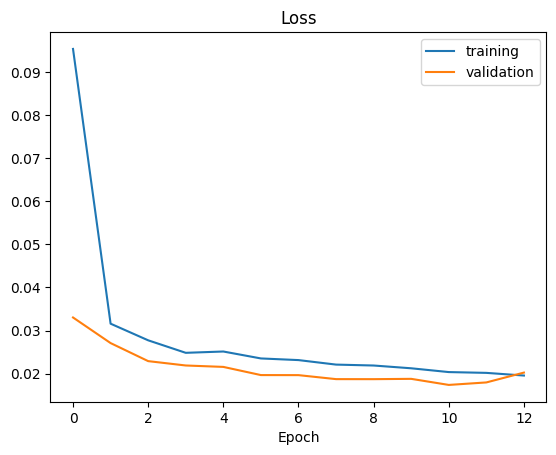

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [23]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>